## Environmental Source Apportionment Toolkit (ESAT) Solution Eval


In [1]:
# Notebook imports
import os
import sys
import json
import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Code Imports

In [2]:
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.metrics import q_loss, qr_loss
from esat_eval.simulator import Simulator

#### Synthetic Dataset

Generate a synthetic dataset where the factor profiles and contributions are pre-determined for model output analysis.

In [3]:
# Synethic dataset parameters
seed = 42
syn_factors = 6
syn_features = 40
syn_samples = 200
contribution_max = 10
noise_mean = 0.1
noise_var = 0.02
uncertainty_mean = 0.05
uncertainty_var = 0.01

In [4]:
simulator = Simulator(seed=seed,
                      factors_n=syn_factors,
                      features_n=syn_features,
                      samples_n=syn_samples,
                      contribution_max=contribution_max,
                      noise_mean=noise_mean,
                      noise_var=noise_var,
                      uncertainty_mean=uncertainty_mean,
                      uncertainty_var=uncertainty_var
                     )

17-Apr-24 11:16:06 - Synthetic profiles generated
17-Apr-24 11:16:06 - Synthetic data generated
17-Apr-24 11:16:06 - Synthetic uncertainty data generated
17-Apr-24 11:16:06 - Synthetic dataframes completed
17-Apr-24 11:16:06 - Synthetic source apportionment instance created.


#### Input Parameters

In [5]:
index_col = "Date"                  # the index of the input/uncertainty datasets
factors = syn_factors               # the number of factors
method = "ls-nmf"                   # "ls-nmf", "ws-nmf"
models = 20                         # the number of models to train
init_method = "col_means"           # default is column means "col_means", "kmeans", "cmeans"
init_norm = True                    # if init_method=kmeans or cmeans, normalize the data prior to clustering.
seed = 42                           # random seed for initialization
max_iterations = 20000              # the maximum number of iterations for fitting a model
converge_delta = 0.1                # convergence criteria for the change in loss, Q
converge_n = 10                     # convergence criteria for the number of steps where the loss changes by less than converge_delta
verbose = True                      # adds more verbosity to the algorithm workflow on execution.
optimized = True                    # use the Rust code if possible
parallel = True                     # execute the model training in parallel, multiple models at the same time

#### Load Data
Assign the processed data and uncertainty datasets to the variables V and U. These steps will be simplified/streamlined in a future version of the code.

In [34]:
syn_input_df, syn_uncertainty_df = simulator.get_data()
# syn_input_df.shape

(200, 41)

In [7]:
data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
V, U = data_handler.get_data()

#### Input/Uncertainty Data Metrics and Visualizations

In [8]:
# Show the input data metrics, including signal to noise ratio of the data and uncertainty
data_handler.metrics

Category        S/N           Min          25th          50th  \
Feature 1    Strong  19.980981  4.350535e-02  1.966812e+00  3.123011e+00   
Feature 2    Strong  19.535813  2.161178e-02  2.946828e-01  3.878713e-01   
Feature 3    Strong  19.692969  4.237897e+00  1.152646e+01  1.444405e+01   
Feature 4    Strong  19.791625  1.468547e-02  1.373049e+00  2.907400e+00   
Feature 5    Strong  20.043652  3.905826e+00  1.084774e+01  1.413122e+01   
Feature 6    Strong  19.278814  8.563703e-03  1.186645e+00  2.535106e+00   
Feature 7    Strong  19.560330  1.761892e+00  6.997071e+00  8.895444e+00   
Feature 8    Strong  19.606090  3.739163e-01  2.965592e+00  4.144995e+00   
Feature 9    Strong  20.307295  8.551329e-01  8.481160e+00  1.140499e+01   
Feature 10   Strong  19.752805  1.937302e+00  1.086833e+01  1.438724e+01   
Feature 11   Strong  20.595747  2.192725e+00  1.151554e+01  1.438807e+01   
Feature 12   Strong  20.040732  2.225318e+00  8.121415e+00  9.720143e+00   
Feature 13   Strong  20.114277  5.980384e-01  5.657320e+00  8.514584e+00   
Feature 14   Strong  19.375350  9.519248e-01  1.039318e+01  1.356216e+01   
Feature 15   Strong  20.363560  1.357212e+00  8.891854e+00  1.148713e+01   
Feature 16   Strong  19.637772  2.945687e+00  9.367677e+00  1.202954e+01   
Feature 17   Strong  19.743041  4.386925e-01  6.897823e+00  9.845650e+00   
Feature 18   Strong  19.244933  1.768925e+00  1.281097e+01  1.602241e+01   
Feature 19   Strong  20.007323  4.056814e-02  2.051148e+00  4.187057e+00   
Feature 20   Strong  21.201237  2.285161e+00  1.297627e+01  1.641066e+01   
Feature 21   Strong  20.005906  4.765228e-03  2.689532e+00  5.016525e+00   
Feature 22   Strong  19.903410  5.546254e+00  1.508382e+01  1.871529e+01   
Feature 23   Strong  19.980078  2.128461e+00  1.018946e+01  1.323890e+01   
Feature 24   Strong  19.674450  1.601168e+00  9.174253e+00  1.138777e+01   
Feature 25   Strong  19.730654  5.157940e+00  1.306074e+01  1.759804e+01   
Feature 26   Strong  20.144834  3.024510e-01  3.618231e+00  4.948485e+00   
Feature 27   Strong  20.087963  1.797647e-02  2.643487e+00  5.467298e+00   
Feature 28   Strong  19.807005  3.899005e-02  3.265922e+00  5.589768e+00   
Feature 29   Strong  20.041647  6.731266e-02  6.995812e-01  9.973965e-01   
Feature 30   Strong  20.231017  8.953957e-04  4.994269e-01  9.150454e-01   
Feature 31   Strong  19.835120  7.552471e-01  7.126461e+00  1.045077e+01   
Feature 32   Strong  20.036680  5.547750e+00  1.471098e+01  1.839682e+01   
Feature 33   Strong  19.826480  3.155505e+00  1.284285e+01  1.627781e+01   
Feature 34   Strong  20.055218  5.089683e-01  4.932962e+00  6.494339e+00   
Feature 35   Strong  19.333098  3.490023e-03  1.690581e-01  3.940181e-01   
Feature 36   Strong  20.469511  3.576904e-01  2.670291e+00  4.322768e+00   
Feature 37   Strong  19.719366  1.268661e+00  5.238794e+00  8.277695e+00   
Feature 38   Strong  19.694531  1.446585e-02  1.381396e+00  2.896024e+00   
Feature 39   Strong  19.556126  3.078081e-01  2.641880e+00  4.558764e+00   
Feature 40   Strong  20.172458  4.143701e-01  5.767426e+00  8.083285e+00   
Date         Strong   0.000000  1.713312e+18  1.717610e+18  1.721909e+18   

                    75th           Max  
Feature 1   4.569360e+00  6.103621e+00  
Feature 2   5.539997e-01  7.865284e-01  
Feature 3   1.711031e+01  2.512436e+01  
Feature 4   4.791406e+00  6.345446e+00  
Feature 5   1.776983e+01  2.610485e+01  
Feature 6   3.934569e+00  5.242921e+00  
Feature 7   1.098756e+01  1.551883e+01  
Feature 8   5.207141e+00  7.569576e+00  
Feature 9   1.451889e+01  2.170371e+01  
Feature 10  1.747168e+01  2.404396e+01  
Feature 11  1.744264e+01  2.534970e+01  
Feature 12  1.200059e+01  1.628457e+01  
Feature 13  1.063662e+01  1.484265e+01  
Feature 14  1.718164e+01  2.628260e+01  
Feature 15  1.343273e+01  1.903785e+01  
Feature 16  1.448425e+01  1.993223e+01  
Feature 17  1.203031e+01  1.704373e+01  
Feature 18  1.923045e+01  2.562435e+01  
Feature 19  6.561660e+00  8.930311e+00 

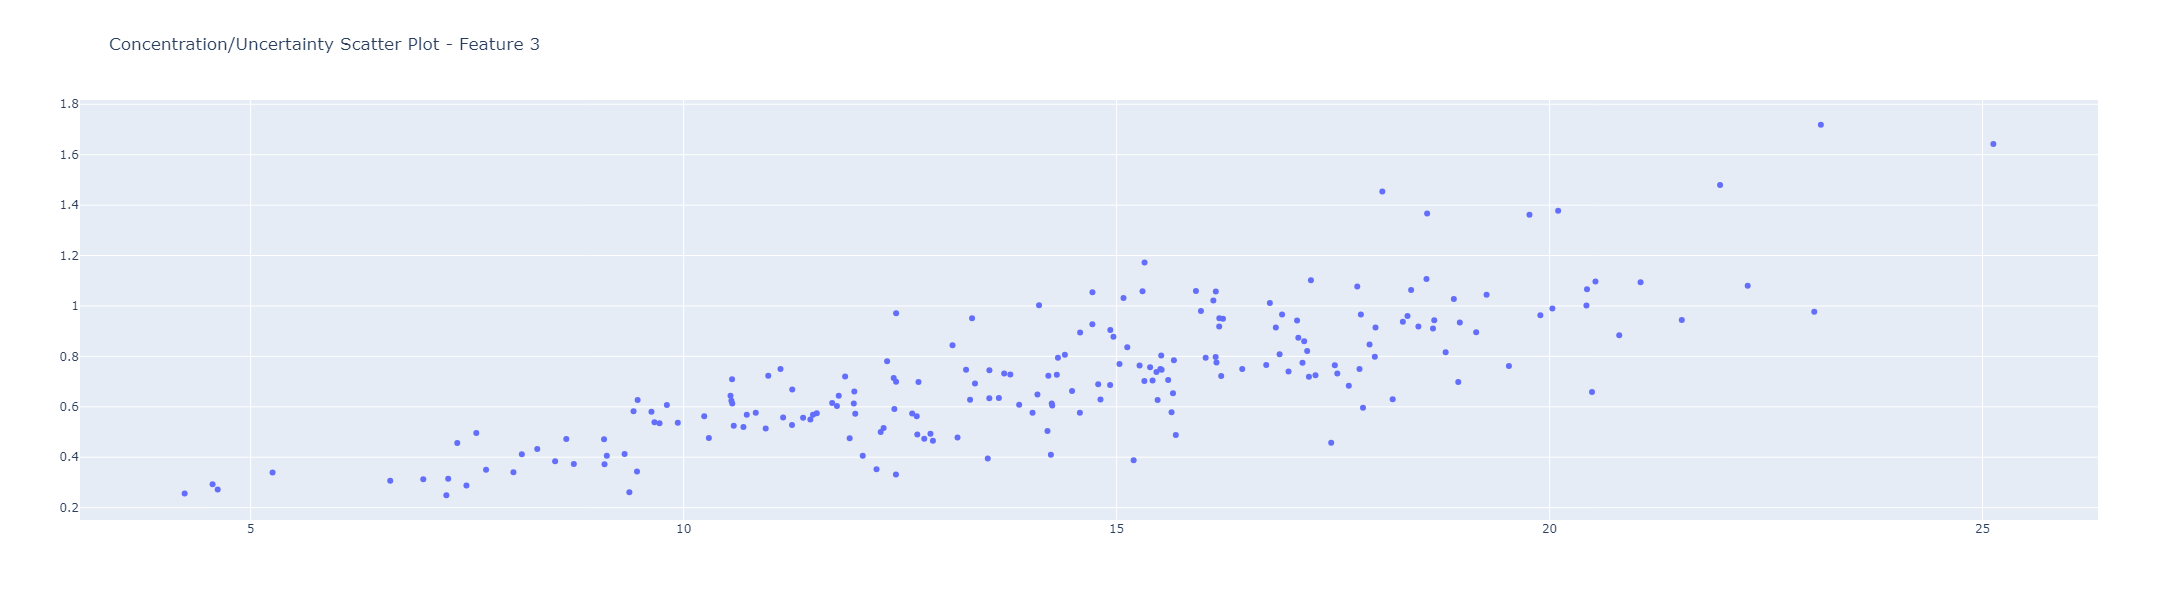

In [9]:
# Concentration / Uncertainty Scatter plot for specific feature, feature/column specified by index
data_handler.plot_data_uncertainty(feature_idx=2)

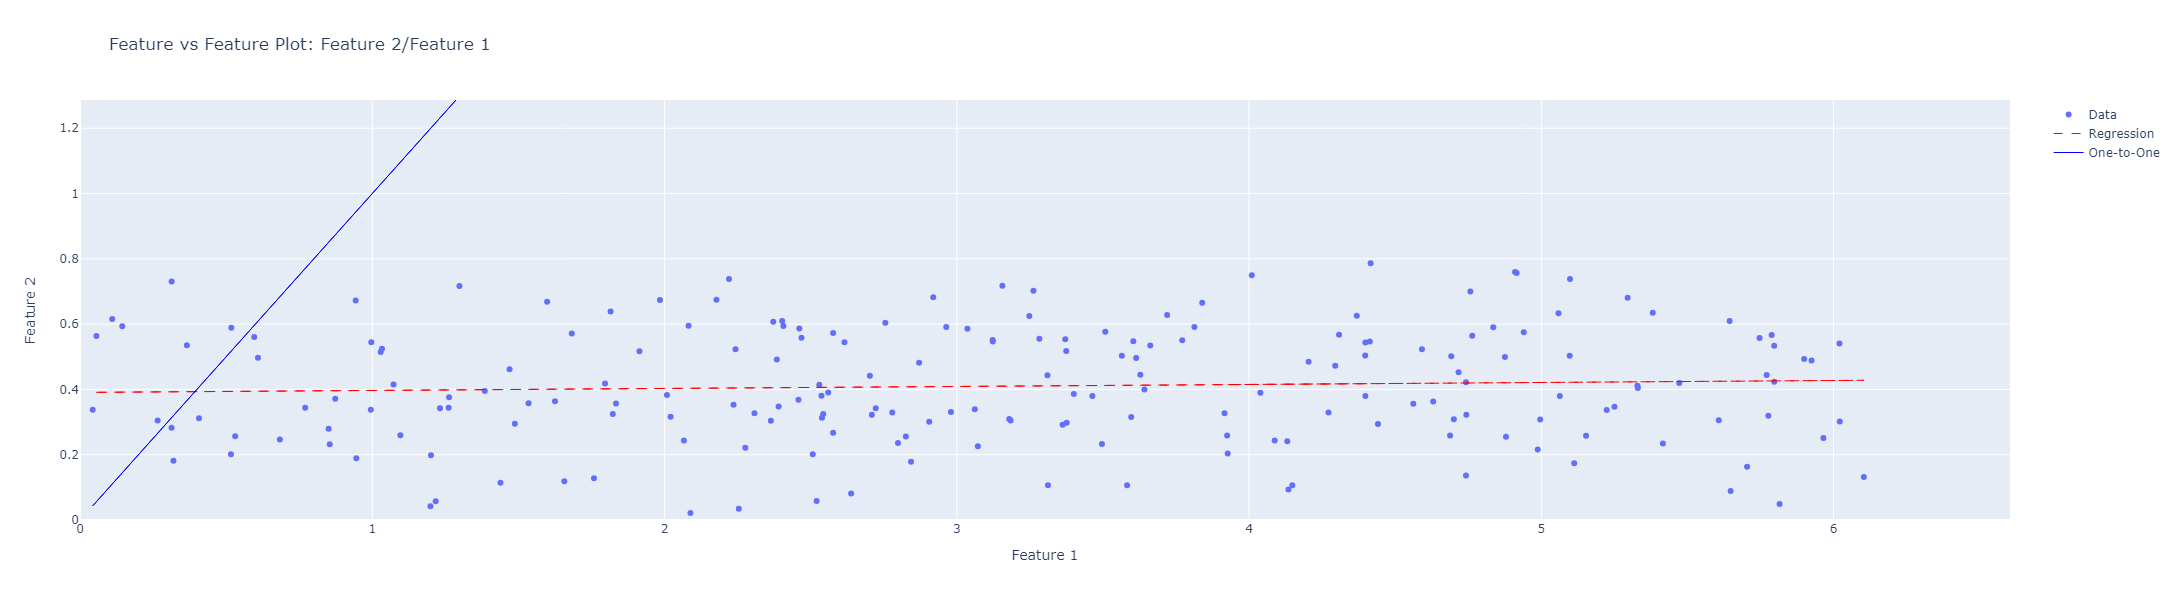

In [10]:
# Species Concentration plot comparing features, features/columns specified by index
data_handler.plot_feature_data(x_idx=0, y_idx=1)

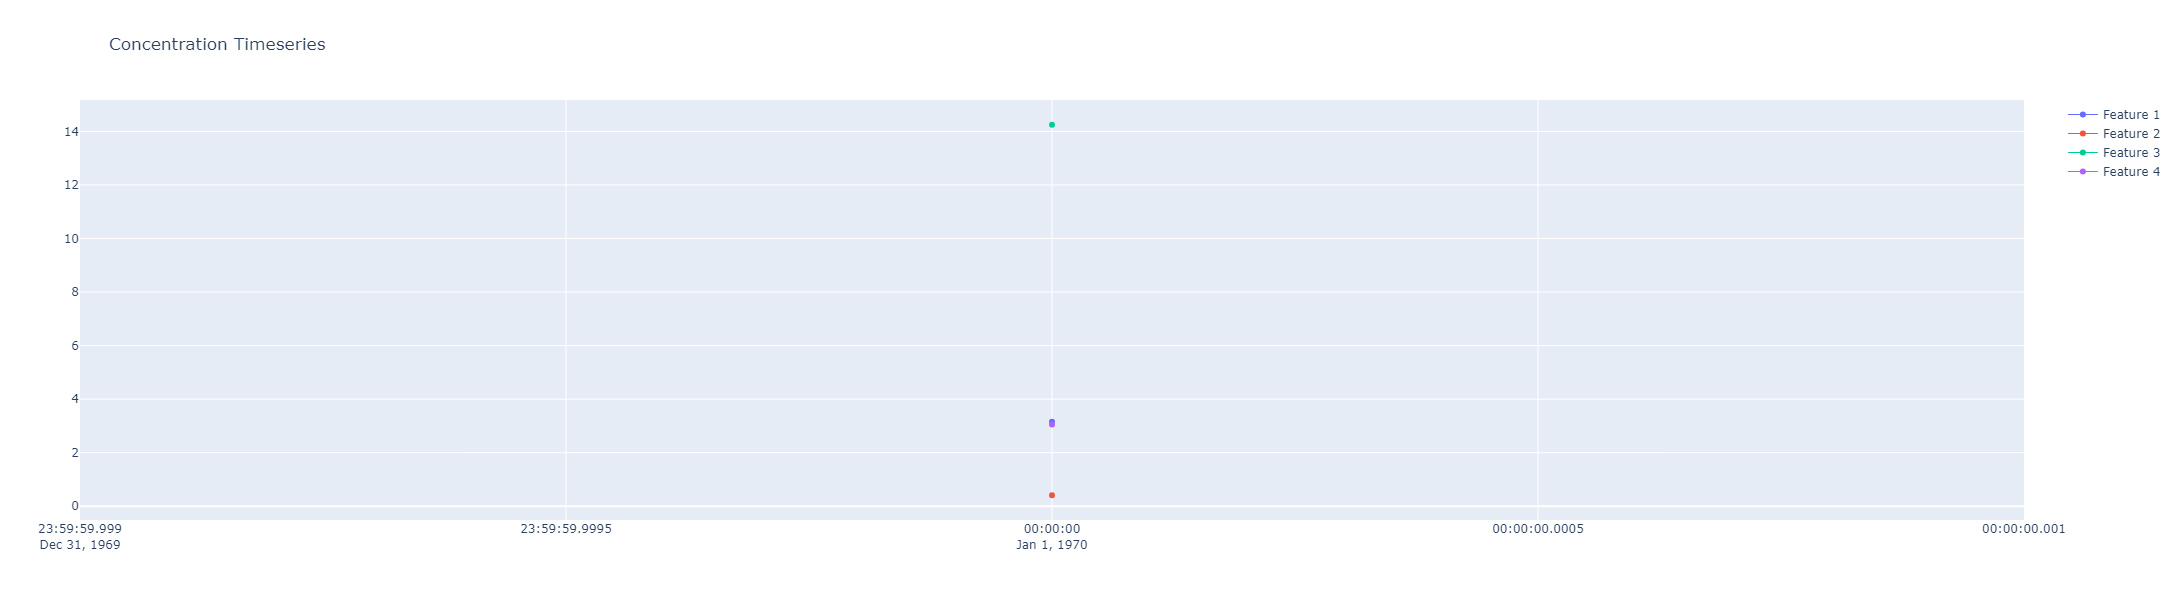

In [11]:
# Species Timeseries, a single or list of features/columns specified by index
data_handler.plot_feature_timeseries(feature_selection=[0, 1, 2, 3])

In [12]:
%%time
# Training multiple models, optional parameters are commented out.
sa_models = BatchSA(V=V, U=U, factors=factors, models=models, method=method, seed=seed, max_iter=max_iterations,
                    init_method=init_method, init_norm=init_norm,
                    converge_delta=converge_delta, converge_n=converge_n, 
                    parallel=parallel, optimized=optimized,
                    verbose=verbose
                   )
_ = sa_models.train()

17-Apr-24 11:16:15 - Model: 1, Q(true): 2987.8243, Q(robust): 1815.8252, Seed: 8925, Converged: True, Steps: 3359/20000
17-Apr-24 11:16:15 - Model: 2, Q(true): 3047.7539, Q(robust): 1849.4143, Seed: 77395, Converged: True, Steps: 1770/20000
17-Apr-24 11:16:15 - Model: 3, Q(true): 1016.9098, Q(robust): 1016.9098, Seed: 65457, Converged: True, Steps: 1388/20000
17-Apr-24 11:16:15 - Model: 4, Q(true): 1016.7305, Q(robust): 1016.7305, Seed: 43887, Converged: True, Steps: 1435/20000
17-Apr-24 11:16:15 - Model: 5, Q(true): 1030.0423, Q(robust): 1030.0423, Seed: 43301, Converged: True, Steps: 2916/20000
17-Apr-24 11:16:15 - Model: 6, Q(true): 1053.3572, Q(robust): 1053.3572, Seed: 85859, Converged: True, Steps: 1651/20000
17-Apr-24 11:16:15 - Model: 7, Q(true): 1054.8529, Q(robust): 1054.8529, Seed: 8594, Converged: True, Steps: 2716/20000
17-Apr-24 11:16:15 - Model: 8, Q(true): 1513.1102, Q(robust): 1401.8854, Seed: 69736, Converged: True, Steps: 2985/20000
17-Apr-24 11:16:15 - Model: 9, Q(t

CPU times: total: 328 ms
Wall time: 7.46 s


#### Train Model

In [13]:
# Selet the best performing model to review
best_model = sa_models.best_model
sa_model = sa_models.results[best_model]
best_model

13

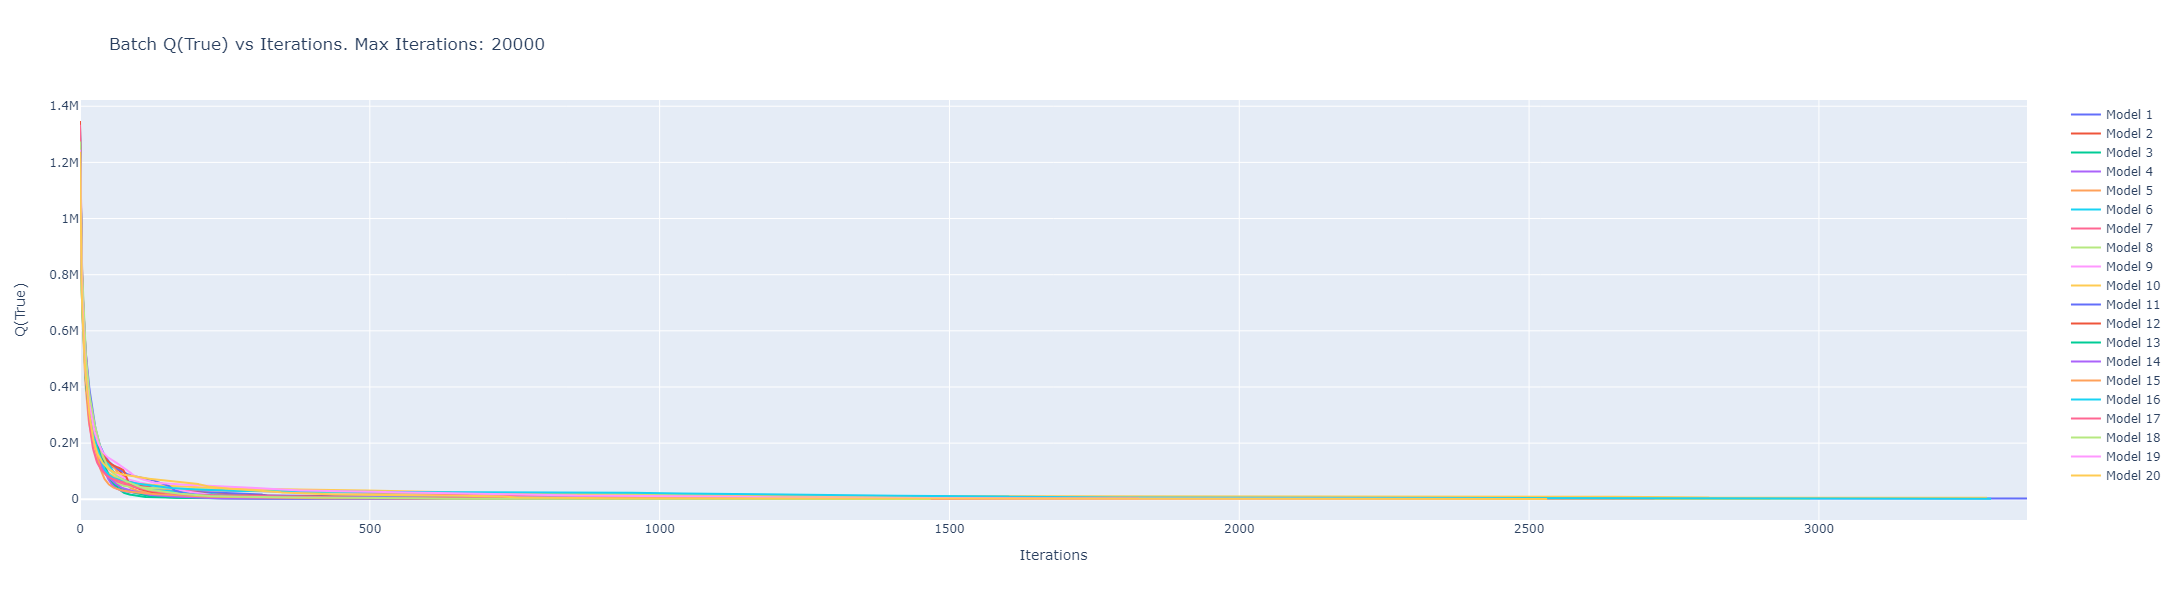

In [14]:
# Perform batch model analysis
batch_analysis = BatchAnalysis(batch_sa=sa_models)
# Plot the loss of the models over iterations
batch_analysis.plot_loss()

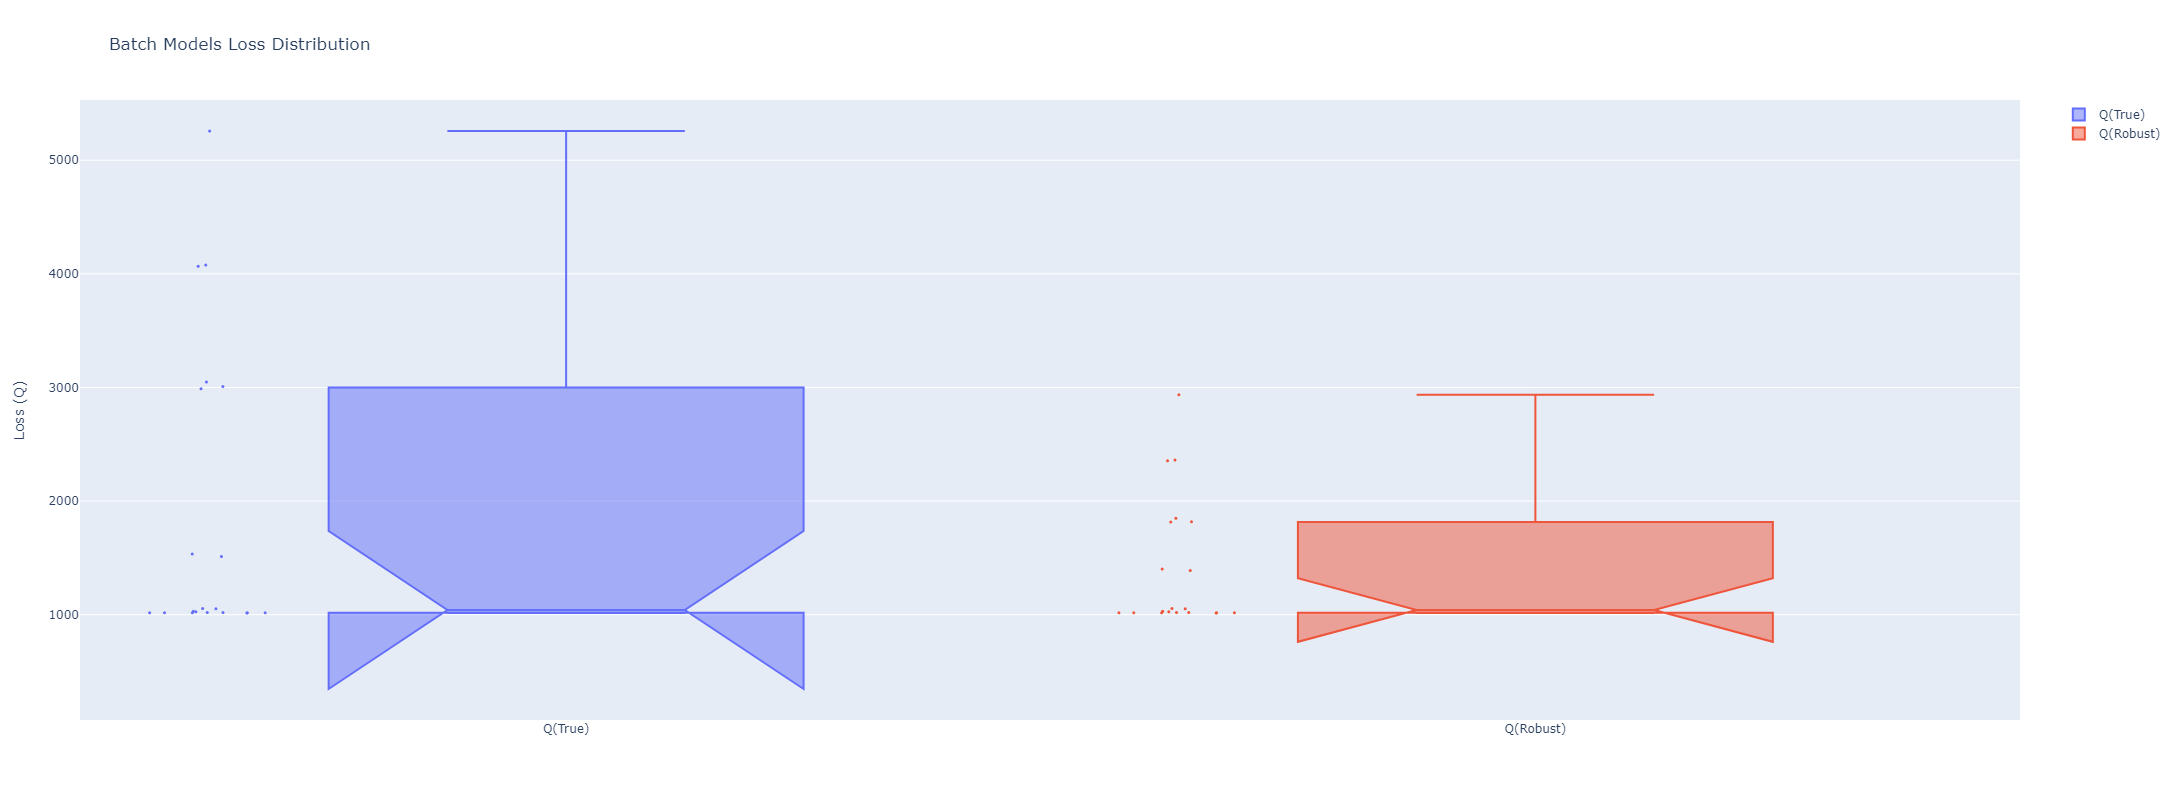

In [15]:
# Plot the loss distribution for the batch models
batch_analysis.plot_loss_distribution()

In [16]:
# Initialize the Model Analysis module
model_analysis = ModelAnalysis(datahandler=data_handler, model=sa_model, selected_model=best_model)

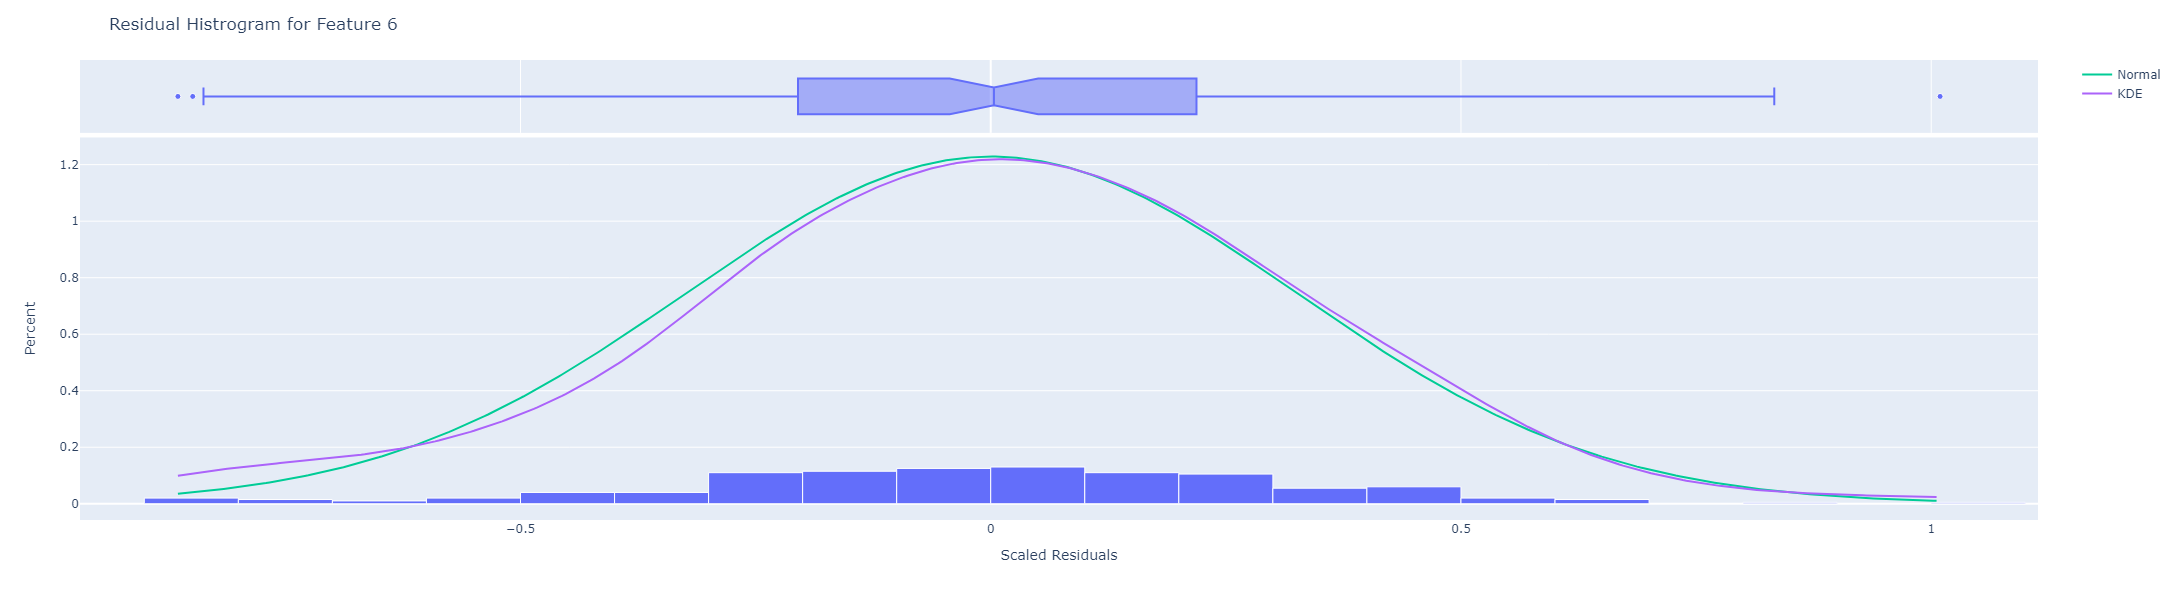

In [17]:
# Residual Analysis shows the scaled residual histogram, along with metrics and distribution curves. The abs_threshold parameter specifies the condition for the returned values of the function call as those residuals which exceed the absolute value of that threshold.
abs_threshold = 3.0
threshold_residuals = model_analysis.plot_residual_histogram(feature_idx=5, abs_threshold=abs_threshold)

In [18]:
print(f"List of Absolute Scaled Residual Greather than: {abs_threshold}. Count: {threshold_residuals.shape[0]}")
threshold_residuals

List of Absolute Scaled Residual Greather than: 3.0. Count: 0


Empty DataFrame
Columns: [Feature 6, datetime]
Index: []

In [19]:
# The model output statistics for the estimated V, including SE: Standard Error metrics, and 3 normal distribution tests of the residuals (KS Normal is used in PMF5)
model_analysis.calculate_statistics()
model_analysis.statistics

Features Category        r2     Intercept  Intercept SE     Slope  \
0    Feature 1   Strong  0.998692  9.197982e-03  9.092288e-03  0.996682   
1    Feature 2   Strong  0.997613 -4.344701e-04  1.554702e-03  1.000940   
2    Feature 3   Strong  0.995851  8.840621e-02  6.739260e-02  0.994216   
3    Feature 4   Strong  0.999121 -5.153777e-03  7.539618e-03  1.002563   
4    Feature 5   Strong  0.996675  6.731677e-02  6.152297e-02  0.994779   
5    Feature 6   Strong  0.998794 -1.972937e-04  7.371049e-03  1.000302   
6    Feature 7   Strong  0.996112  5.134402e-02  4.094479e-02  0.994417   
7    Feature 8   Strong  0.997905  4.965011e-03  1.417080e-02  0.997250   
8    Feature 9   Strong  0.997758  5.043414e-02  4.041130e-02  0.995469   
9   Feature 10   Strong  0.996992  5.233966e-02  5.730514e-02  0.996781   
10  Feature 11   Strong  0.997006  4.522175e-02  5.838976e-02  0.995681   
11  Feature 12   Strong  0.994849  8.453239e-02  5.239775e-02  0.990120   
12  Feature 13   Strong  0.998019 -2.988141e-03  2.766698e-02  1.000355   
13  Feature 14   Strong  0.997124  6.865621e-02  5.534849e-02  0.993733   
14  Feature 15   Strong  0.996806  1.823871e-02  4.646482e-02  0.996664   
15  Feature 16   Strong  0.995823  2.520744e-02  5.717086e-02  0.997005   
16  Feature 17   Strong  0.997813  4.058686e-02  3.354355e-02  0.995441   
17  Feature 18   Strong  0.996074  1.015408e-01  7.336279e-02  0.994205   
18  Feature 19   Strong  0.999168  5.194680e-03  1.014032e-02  0.998124   
19  Feature 20   Strong  0.995566  1.009321e-01  7.962950e-02  0.993410   
20  Feature 21   Strong  0.998616 -5.544053e-05  1.466417e-02  1.000133   
21  Feature 22   Strong  0.996164  1.229562e-01  8.603588e-02  0.992388   
22  Feature 23   Strong  0.996613  5.342045e-02  5.563832e-02  0.995462   
23  Feature 24   Strong  0.995955  3.915431e-02  5.290777e-02  0.996360   
24  Feature 25   Strong  0.996692  3.582548e-02  7.449398e-02  0.996490   
25  Feature 26   Strong  0.997387  2.338504e-02  1.897542e-02  0.994548   
26  Feature 27   Strong  0.999081 -1.333368e-03  1.338607e-02  0.999564   
27  Feature 28   Strong  0.998383  8.895479e-03  1.737234e-02  0.998787   
28  Feature 29   Strong  0.998160  2.302852e-03  3.285411e-03  0.997565   
29  Feature 30   Strong  0.998594  5.596800e-04  2.692551e-03  0.998013   
30  Feature 31   Strong  0.997196  3.072466e-02  3.963573e-02  0.996039   
31  Feature 32   Strong  0.996433  3.244280e-02  8.179940e-02  0.997729   
32  Feature 33   Strong  0.996479  5.487443e-02  7.114932e-02  0.995784   
33  Feature 34   Strong  0.996431  3.685648e-02  2.849652e-02  0.993970   
34  Feature 35   Strong  0.999084  1.289211e-03  1.043477e-03  0.996671   
35  Feature 36   Strong  0.998100  2.421726e-03  1.499797e-02  0.999293   
36  Feature 37   Strong  0.998333  1.716839e-02  2.507427e-02  0.997542   
37  Feature 38   Strong  0.999186  2.967589e-03  7.281407e-03  0.998446   
38  Feature 39   Strong  0.998600 -7.709972e-04  1.332333e-02  0.999438   
39  Feature 40   Strong  0.997105  3.455045e-02  3.217308e-02  0.995436   
40        Date   Strong  0.001094 -2.808569e+18  9.531486e+18  2.577263   

    Slope SE            SE  SE Regression Anderson Normal Residual  \
0   0.002563  4.168575e-03   5.870473e-02                       No   
1   0.003480  6.150905e-04   8.697090e-03                      2.5   
2   0.004560  1.786827e-02   2.516750e-01                     15.0   
3   0.002114  3.911096e-03   5.510703e-02                     15.0   
4   0.004084  1.906674e-02   2.685381e-01                     15.0   
5   0.002470  3.778462e-03   5.343351e-02                     15.0   
6   0.004415  1.262254e-02   1.777934e-01                     15.0   
7   0.003248  5.005014e-03   7.065372e-02                      5.0   
8   0.003353  1.415569e-02   1.992748e-01                      2.5   
9   0.003891  1.716819e-02   2.423763e-01                     15.0   
10  0.003878  1.753100e-02   2.471528e-01                      1.0   
11  0.005063  1

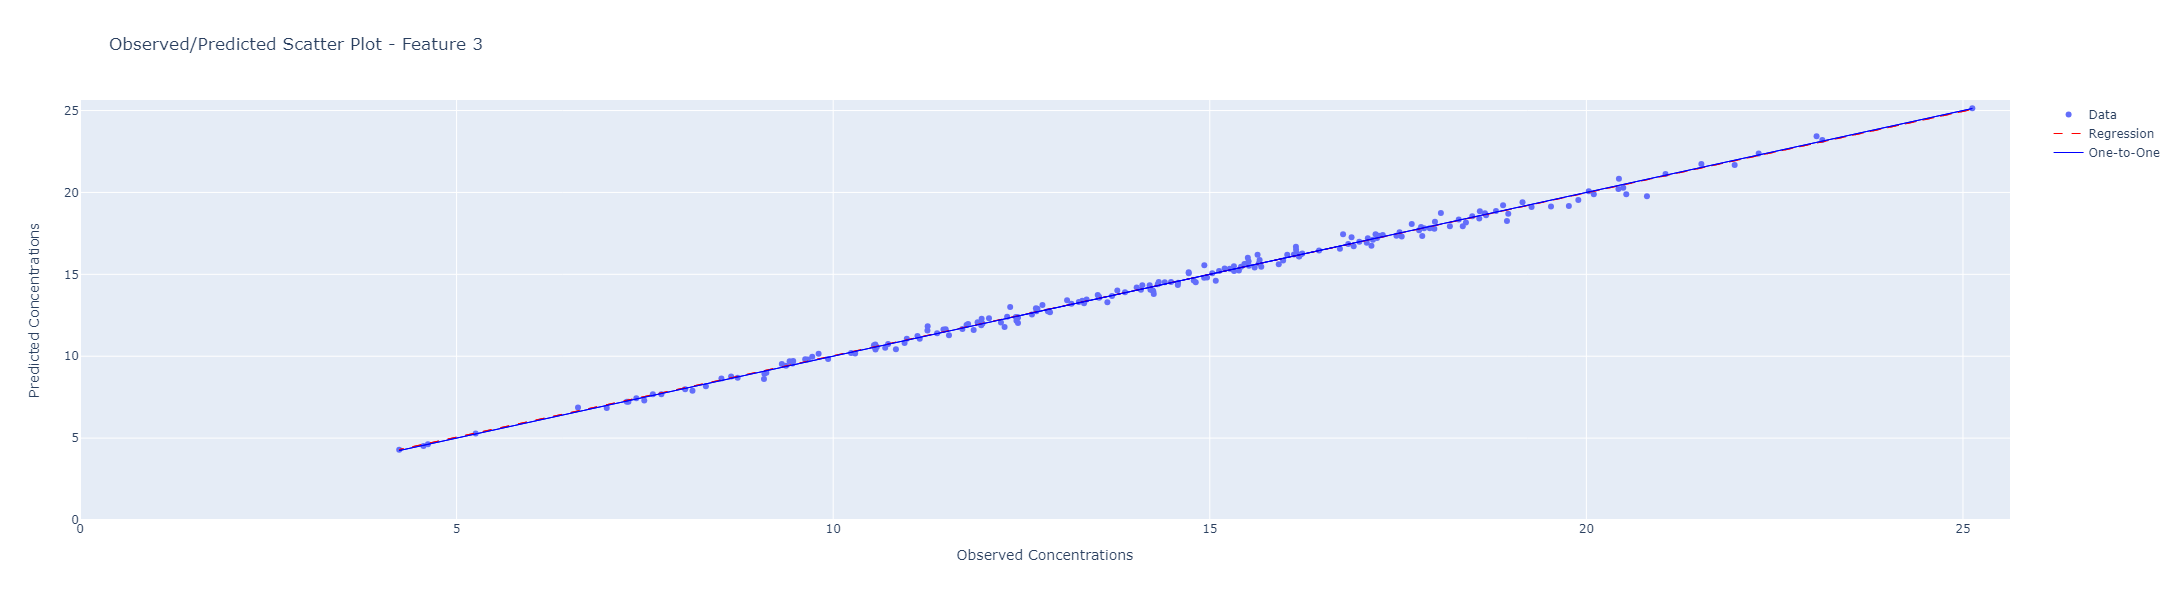

In [20]:
# Model feature observed vs predicted plot with regression and one-to-one lines. Feature/Column specified by index.
model_analysis.plot_estimated_observed(feature_idx=2)

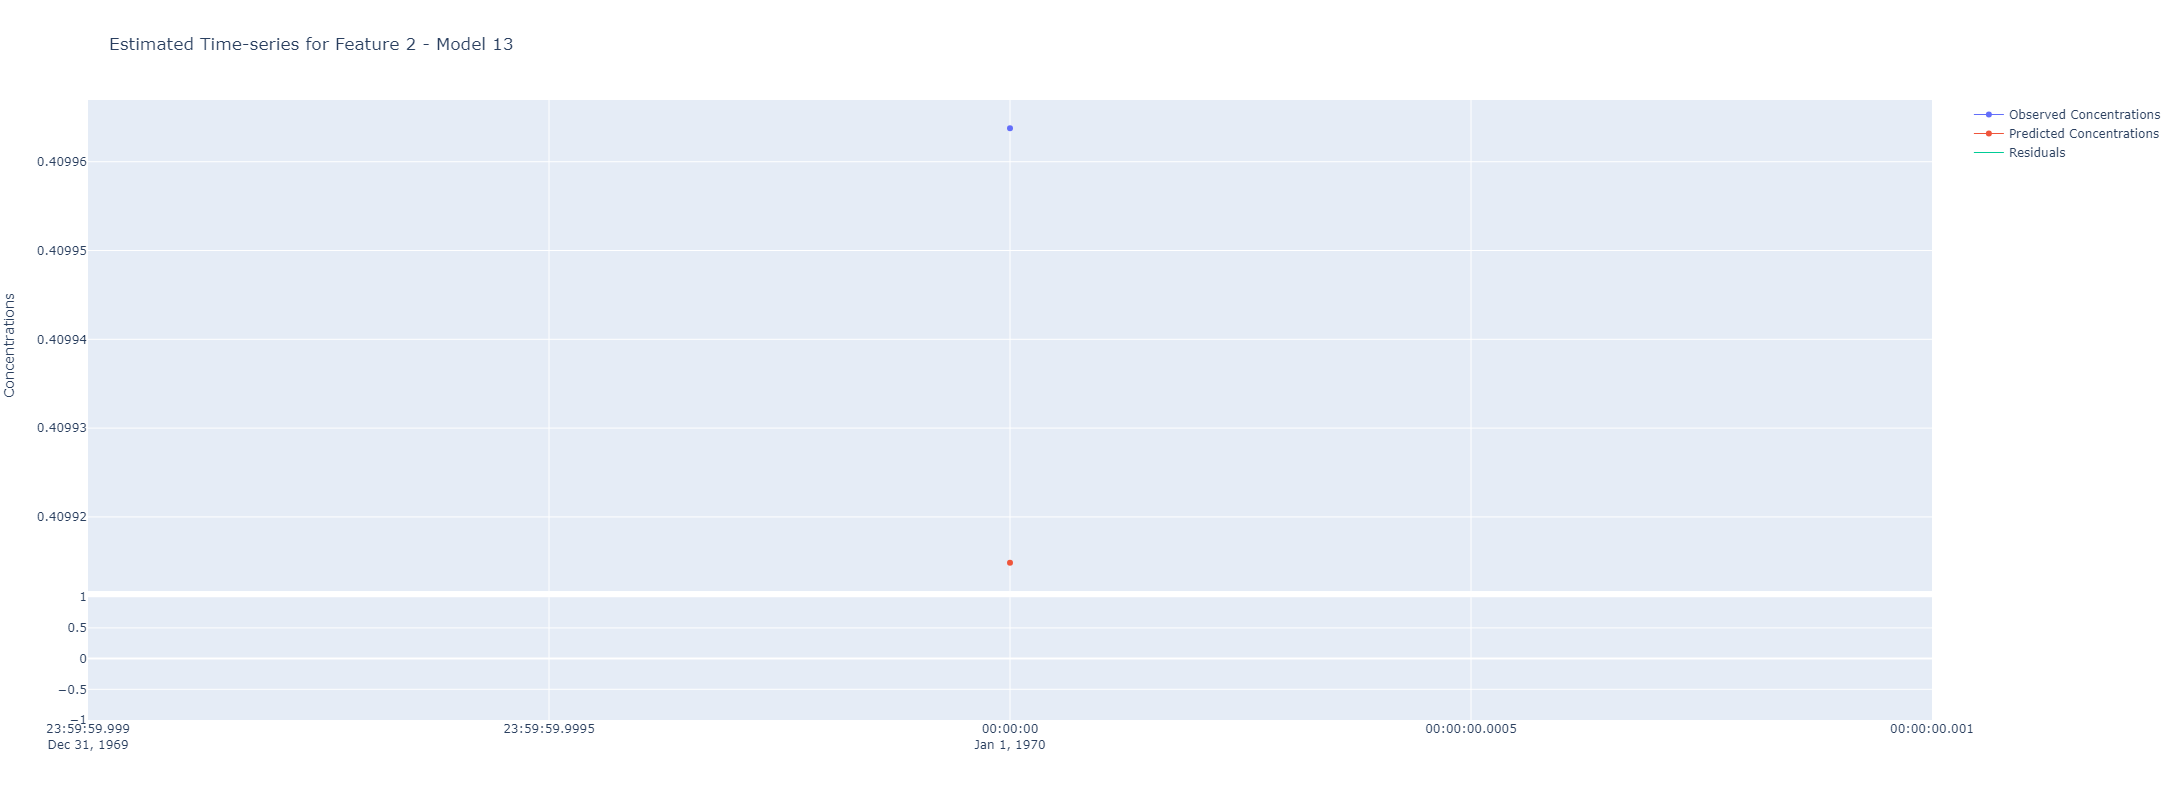

In [21]:
# Model feature timeseries analysis plot showing the observed vs predicted values of the feature, along with the residuals shown below. Feature/column specified by index.
model_analysis.plot_estimated_timeseries(feature_idx=1)

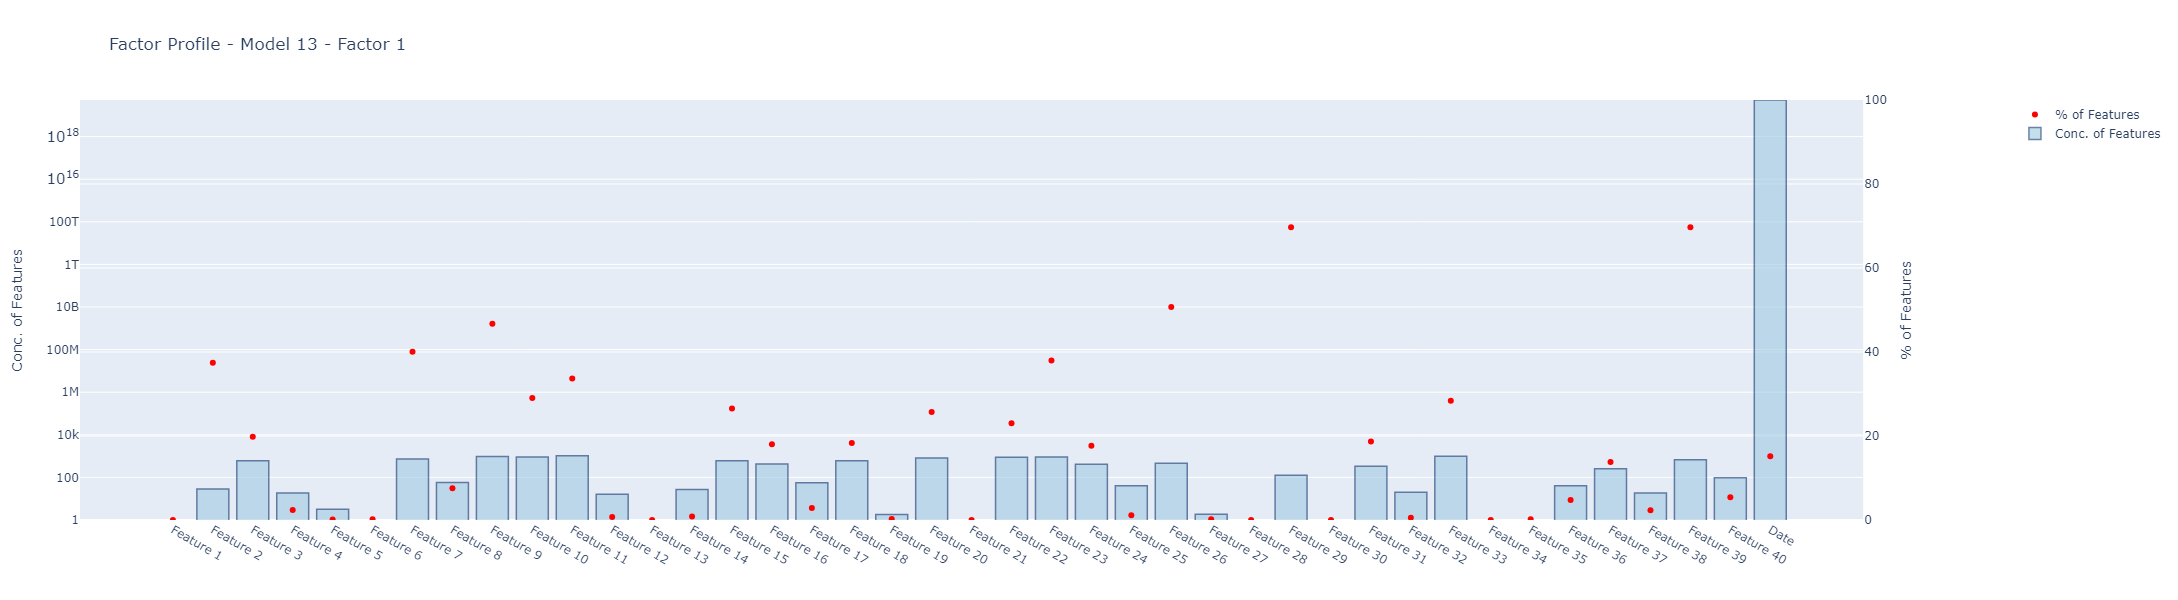

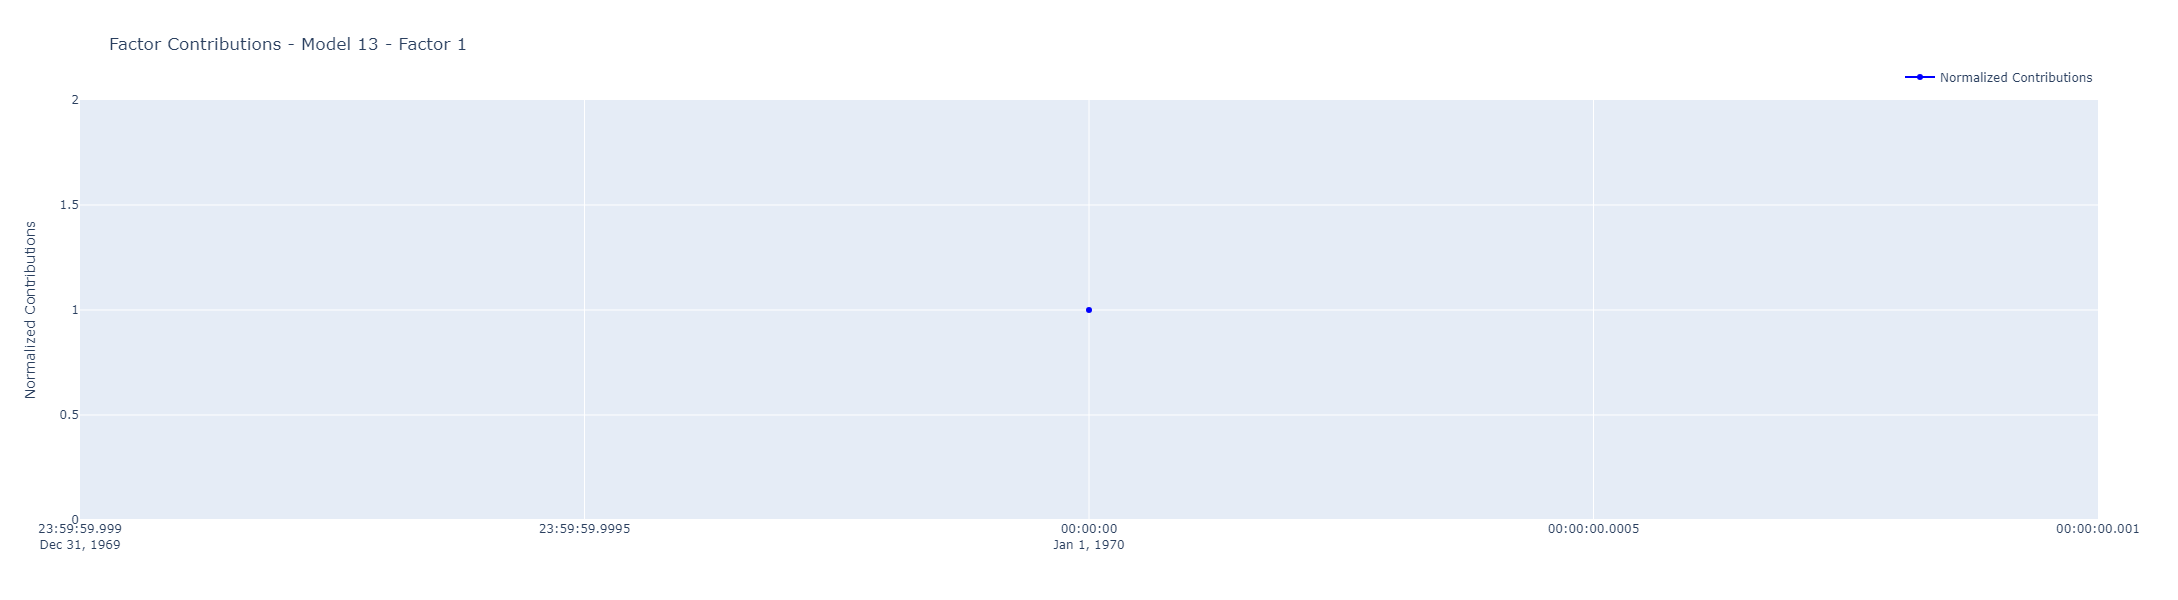

In [22]:
# Factor profile plot showing the factor sum of concentrations by feature (blue bars), the percentage of the feature as the red dot, and in the bottom plot the normalized contributions by date (values are resampled at a daily timestep for timeseries consistency).
# Factor specified by index.
model_analysis.plot_factor_profile(factor_idx=1)

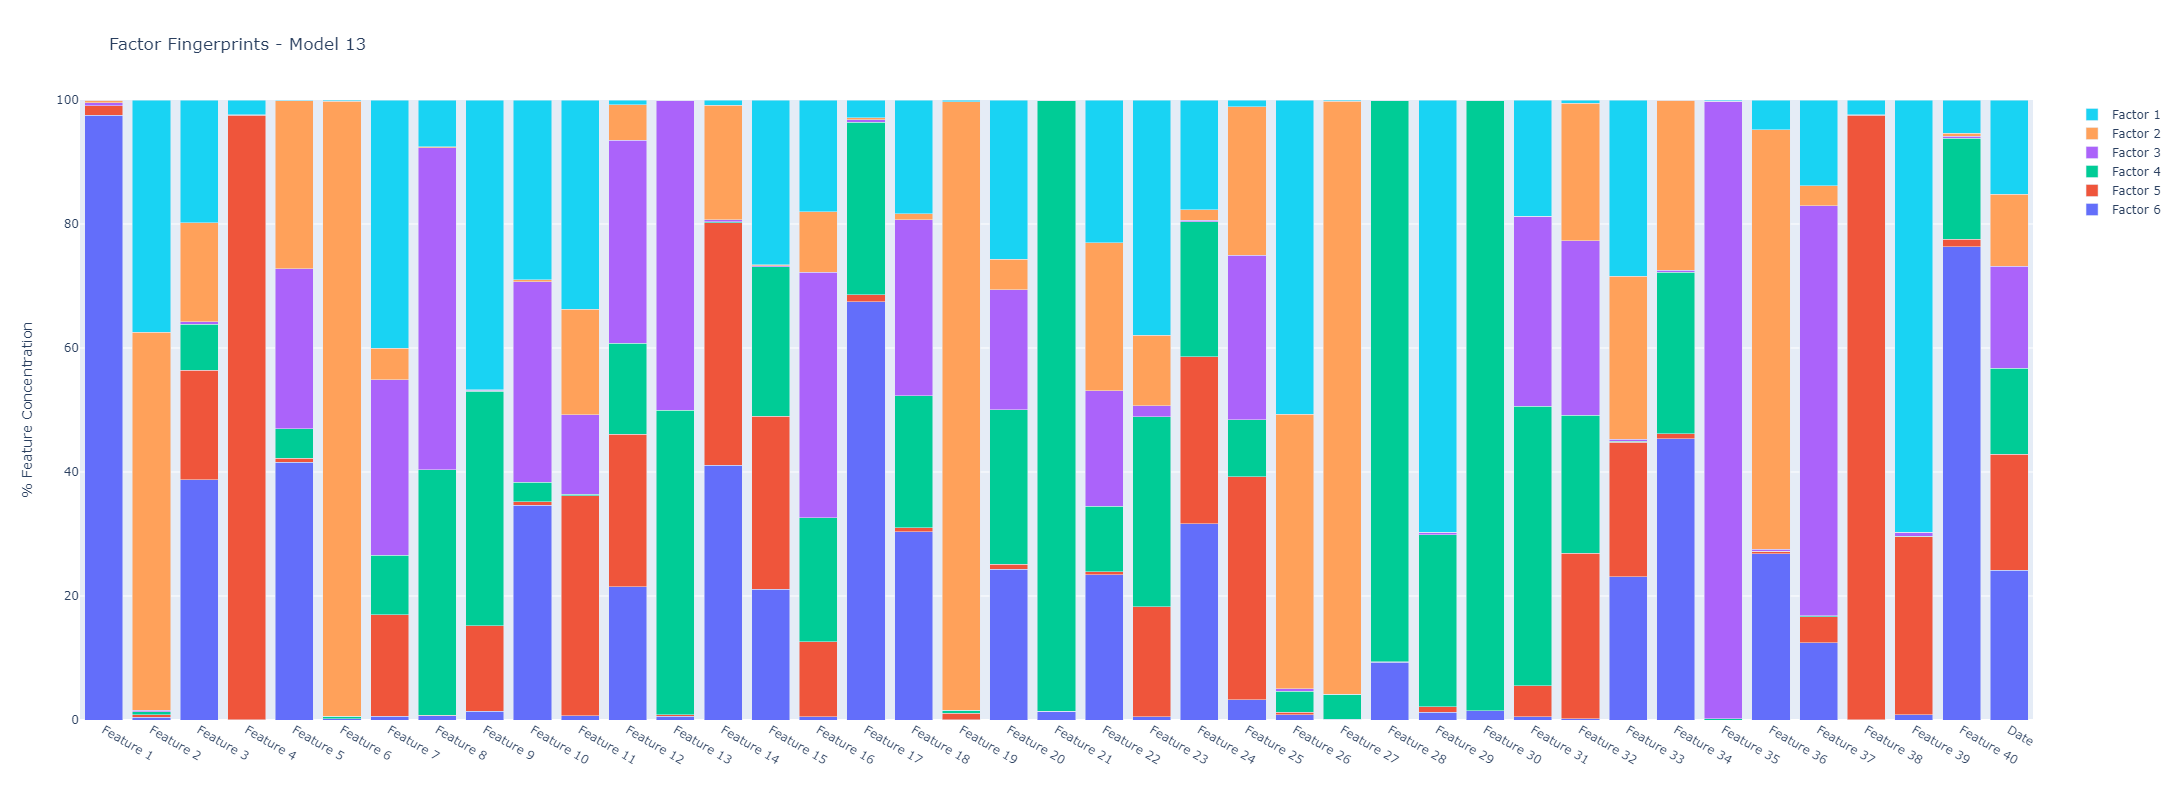

In [23]:
# Model factor fingerprint specifies the feature percentage of each factor.
model_analysis.plot_factor_fingerprints()

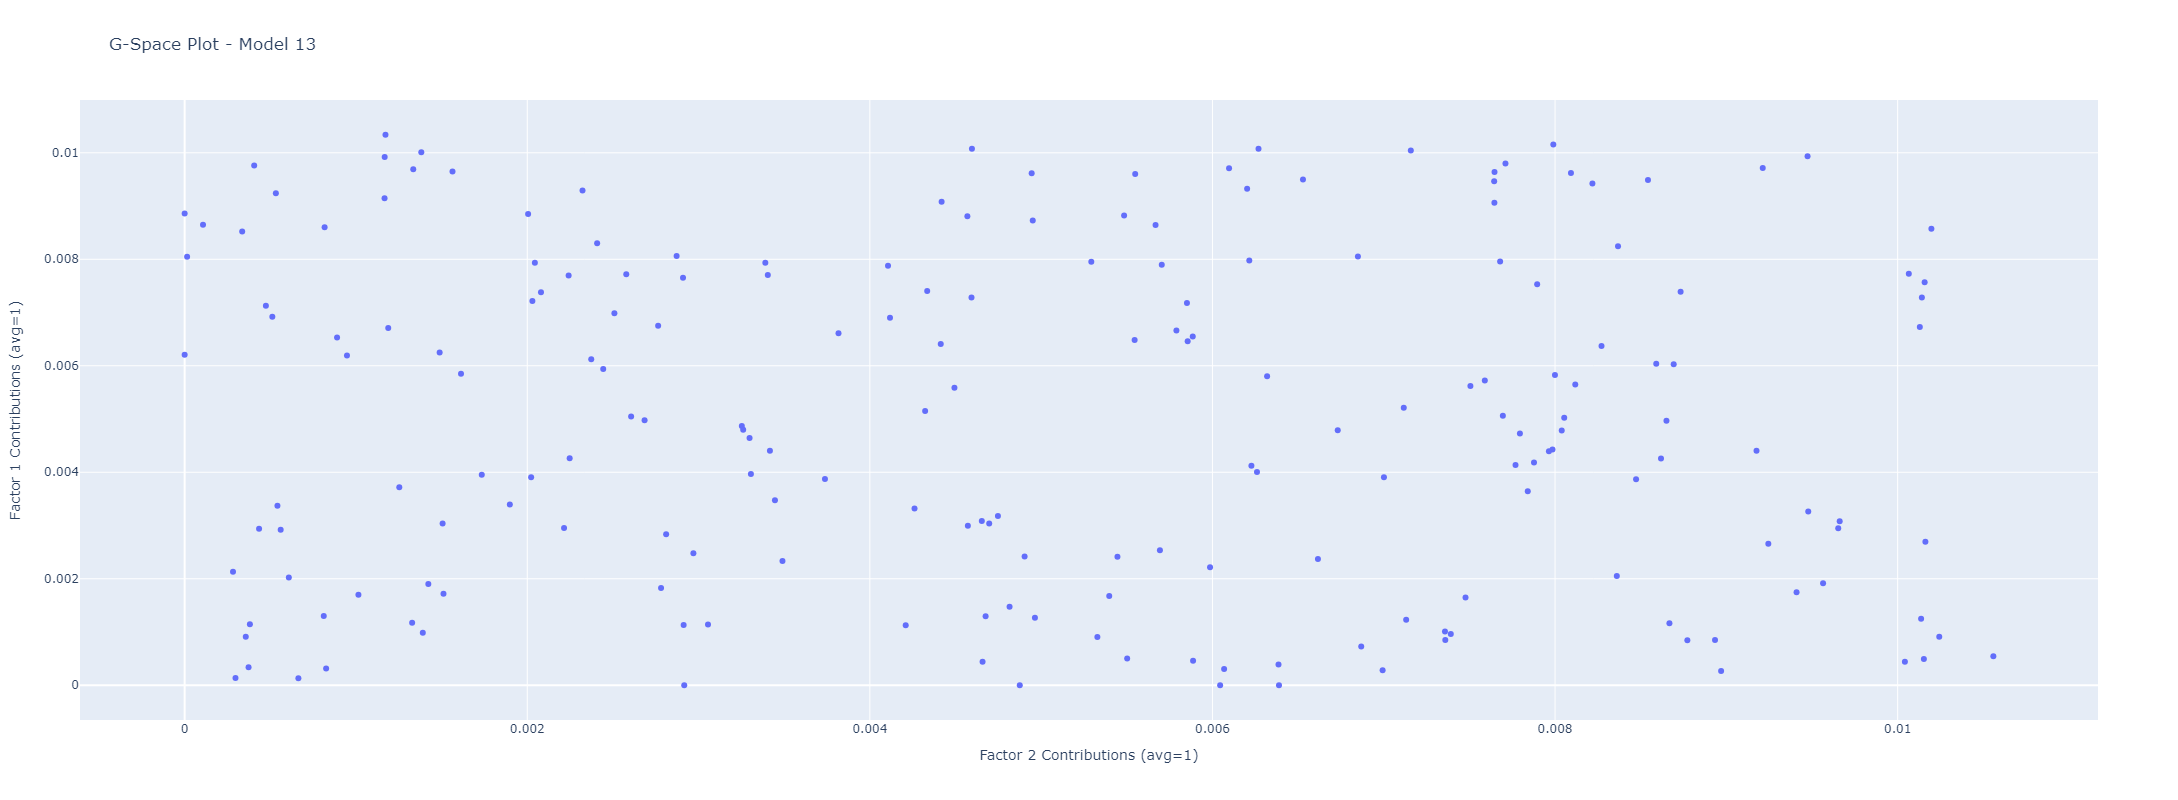

In [24]:
# Factor G-Space plot shows the normalized contributions of one factor vs another factor. Factor specified by index.
model_analysis.plot_g_space(factor_1=2, factor_2=1)

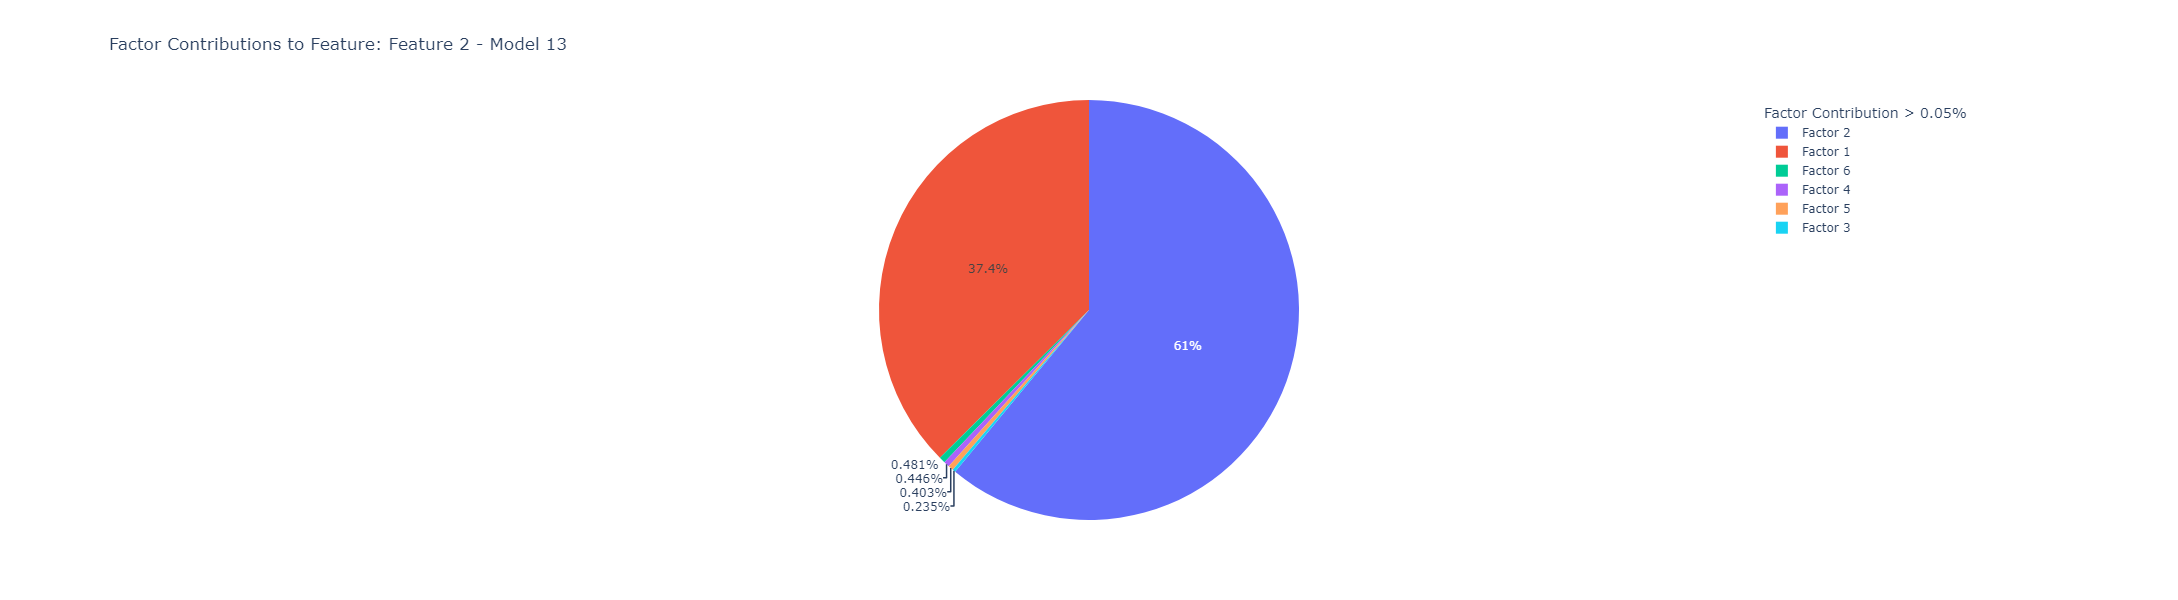

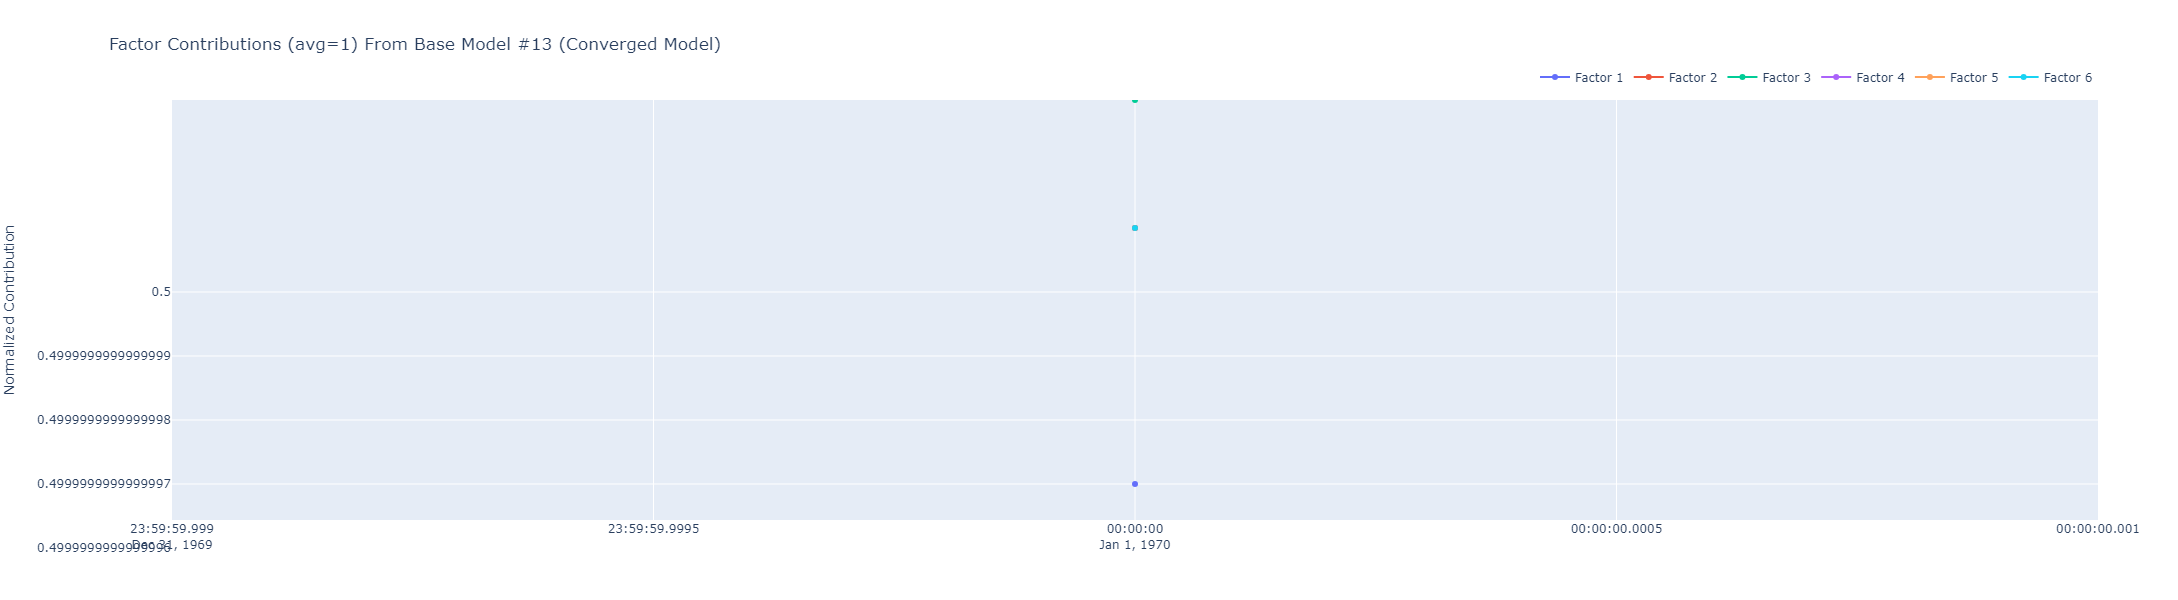

In [25]:
# Factor contribution pie chart shows the percentage of factor contributions for the specified feature, and the corresponding normalized contribution of each factor for that feature (bottom plot). Feature specified by index.
model_analysis.plot_factor_contributions(feature_idx=1)

### Compare to Synthetic Data

Compare the set of batch models to the original synthetic factor data.


In [26]:
simulator.compare(batch_sa=sa_models)

ValueError: Shape of passed values is (6, 41), indices imply (6, 40)

In [ ]:
simulator.plot_comparison()

In [30]:
# simulator.syn_profiles_df
simulator.syn_factor_columns

['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6']

In [33]:
sa_models.results[0].H

array([[4.86443465e-51, 9.78251091e-10, 2.17738155e-08, 8.83672247e-10,
        1.20836504e-11, 1.58761025e-19, 2.55795489e-08, 1.96658599e-09,
        3.32075720e-08, 3.17782612e-08, 3.72656402e-08, 1.12233320e-09,
        1.12440401e-14, 2.44419947e-09, 2.13639949e-08, 1.50282763e-08,
        1.92664066e-09, 2.06163994e-08, 7.09475893e-11, 2.84573724e-08,
        2.74686113e-36, 3.02430695e-08, 3.14420880e-08, 1.47645063e-08,
        2.75321065e-09, 1.59192773e-08, 5.41987348e-19, 3.73858278e-26,
        4.31899246e-09, 4.78228478e-58, 1.15734685e-08, 2.20062502e-09,
        3.47312337e-08, 2.67152032e-16, 4.95061830e-18, 1.31679913e-09,
        8.73025368e-09, 8.83840171e-10, 2.37386964e-08, 3.29782984e-09,
        1.88445444e+09],
       [4.40275287e-50, 8.24311163e-12, 2.00142493e-10, 8.16247122e-60,
        2.87857889e-08, 8.42173773e-13, 1.88173033e-08, 1.43112574e-08,
        2.04027963e-10, 3.68802576e-08, 1.45115195e-08, 2.60234967e-08,
        2.64830105e-08, 2.39417033e-17,